**Affine Registration in 3D**

This example explains how to compute affine transformation to register two 3D volumes by maximization of their Mutual Information.

*Affine Transformation* - technique used to correct geometric distortions that occur with non-ideal angles.

*Maximization of Mutual Information (MI)* - Used to measure the statistical dependence or information redundancy between the image intensities of corresponding voxels in both images, which is assumed to be maximal if the images are geometrically aligned.


In [1]:
!pip install dipy

     |████████████████████████████████| 8.1MB 4.3MB/s 


In [2]:
#install fury to avoid user warnings !!!
!pip install fury 

     |████████████████████████████████| 153kB 4.7MB/s 
     |████████████████████████████████| 48.9MB 55kB/s 


In [0]:
#Import required libraries and modules
from os.path import join as pjoin
import numpy as np
from dipy.viz import regtools
from dipy.data import fetch_stanford_hardi
from dipy.data.fetcher import fetch_syn_data
from dipy.io.image import load_nifti
from dipy.align.imaffine import (transform_centers_of_mass,
                                 AffineMap,
                                 MutualInformationMetric,
                                 AffineRegistration)
from dipy.align.transforms import (TranslationTransform3D,
                                   RigidTransform3D,
                                   AffineTransform3D)

Let's fetch the two b0 volumes

1.   Static Image from Standford HARDI dataset
2.   Moving image from dipy/io/image.py





In [4]:
#for static image
files, folder = fetch_stanford_hardi()
static_data, static_affine = load_nifti(pjoin(folder, 'HARDI150.nii.gz'))
static = np.squeeze(static_data)[..., 0]
static_grid2world = static_affine

Download Progress: [########################################] 100.00%  of 0.00 MB

In [5]:
#for moving image
iles, folder = fetch_syn_data()
moving_data, moving_affine = load_nifti(pjoin(folder, 'b0.nii.gz'))
moving = moving_data
moving_grid2world = moving_affine

Download Progress: [########################################] 100.00%  of 1.34 MB

We can see below that the images are far aligned by drawing one on top of another.

The images don't even have the same number of voxels, so in order
to draw one on top of the other we need to resample the moving image on a grid
of the same dimensions as the static image.

We can do this by "transforming"
the moving image using an identity transform.

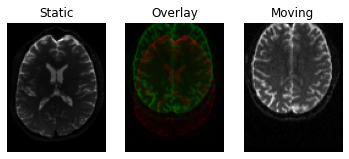

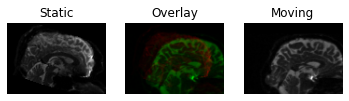

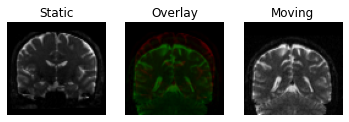

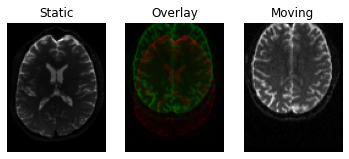

In [6]:
identity = np.eye(4)

affine_map = AffineMap(identity,
                       static.shape, static_grid2world,
                       moving.shape, moving_grid2world)
resampled = affine_map.transform(moving)

#plot 3 overlay images slices from the given volumes
regtools.overlay_slices(static, resampled, None, 0,
                        "Static", "Moving", "resampled_0.png")
regtools.overlay_slices(static, resampled, None, 1,
                        "Static", "Moving", "resampled_1.png")
regtools.overlay_slices(static, resampled, None, 2,
                        "Static", "Moving", "resampled_2.png")

We can obtain a very rough and fast registration by just aligning the centers of mass of the two images.

In [0]:
#align the center of 2 images
c_of_mass = transform_centers_of_mass(static, static_grid2world,
                                      moving, moving_grid2world)

We can now transform the moving image and draw it on top of the static image,
registration is not likely to be good, but at least they will occupy roughly
the same space

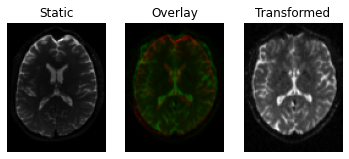

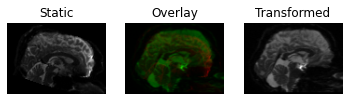

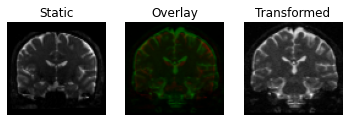

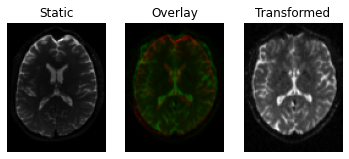

In [8]:
transformed = c_of_mass.transform(moving)

#plot three overlay image slices after being transformed and aligned by center of mass
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_com_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_com_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_com_2.png")


Notice the difference between Moving and Transformed now. It is aligned to the center, transformed and clearer now.

This was just a translation of the moving image towards the static image, now
we will refine it by looking for an affine transform.

We first create the
similarity metric (Mutual Information) to be used.

We need to specify the
number of bins to be used to discretize the joint and marginal probability
distribution functions (PDF), a typical value is 32.

We also need to specify
the percentage (an integer in (0, 100]) of voxels to be used for computing the
PDFs, the most accurate registration will be obtained by using all voxels, but
it is also the most time-consuming choice.

We specify full sampling by passing

None instead of an integer

In [0]:
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)

To avoid getting stuck at local optima, and to accelerate convergence, we use a
multi-resolution strategy by building a Gaussian Pyramid.

To have as much flexibility as possible, the user can specify how this
Gaussian Pyramid is built.

First of all, we need to specify how many
resolutions we want to use.

This is indirectly specified by just providing a list of the number of iterations we want to perform at each resolution.

Here,
we will just specify 3 resolutions and a large number of iterations, 10000 at the
coarsest resolution, 1000 at the medium resolution and 100 at the finest. These
are the default settings



In [0]:
level_iters = [10000, 1000, 100]

To compute the Gaussian pyramid, the original image is first smoothed at each
level of the pyramid using a Gaussian kernel with the requested sigma. A good
initial choice is [3.0, 1.0, 0.0], this is the default

In [0]:
sigmas = [3.0, 1.0, 0.0]

Now we specify the sub-sampling factors. A good configuration is [4, 2, 1],
which means that, if the original image shape was (nx, ny, nz) voxels, then the
shape of the coarsest image will be about (nx//4, ny//4, nz//4), the shape in
the middle resolution will be about (nx//2, ny//2, nz//2) and the image at the
finest scale has the same size as the original image. This set of factors is
the default

In [0]:
factors = [4, 2, 1]

Now we go ahead and instantiate the registration class with the configuration
we just prepared

In [0]:
#affine registration class instantiated 
affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

Using AffineRegistration we can register our images in as many stages as we
want, providing previous results as initialization for the next.

The reason why it is useful is that registration is a non-convex
optimization problem (it may have more than one local optima), which means that
it is very important to initialize as close to the solution as possible. 
For example, let's start with our (previously computed) rough transformation
aligning the centers of mass of our images, and then refine it in three stages.

First look for an optimal translation. The dictionary regtransforms contains
all available transforms, we obtain one of them by providing its name and the
dimension (either 2 or 3) of the image we are working with (since we are
aligning volumes, the dimension is 3)

In [14]:
transform = TranslationTransform3D()
params0 = None
starting_affine = c_of_mass.affine
translation = affreg.optimize(static, moving, transform, params0,
                              static_grid2world, moving_grid2world,
                              starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


If we look at the result, we can see that this translation is much better than
simply aligning the centers of mass

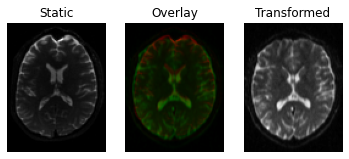

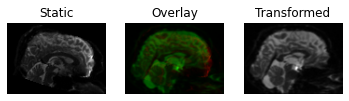

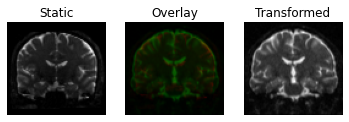

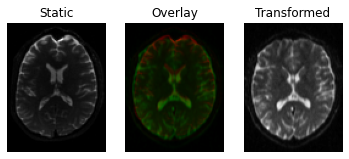

In [15]:
transformed = translation.transform(moving)

#plotting 3 overlay slcices after registering by translating the moving image using Mutual Information
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_trans_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_trans_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_trans_2.png")

Now let's refine with a rigid transform (this may even modify our previously
found optimal translation)

In [16]:
transform = RigidTransform3D()
params0 = None
starting_affine = translation.affine
rigid = affreg.optimize(static, moving, transform, params0,
                        static_grid2world, moving_grid2world,
                        starting_affine=starting_affine)


Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


This produces a slight rotation, and the images are now better aligned

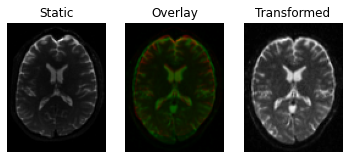

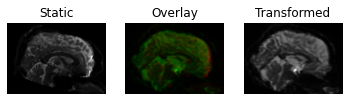

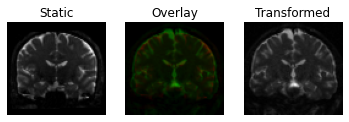

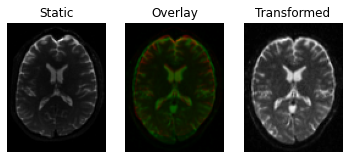

In [17]:
transformed = rigid.transform(moving)

#plotting rigid transforms after using MI
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_rigid_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_rigid_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_rigid_2.png")

Finally, let's refine with a full affine transform (translation, rotation, scale
and shear), it is safer to fit more degrees of freedom now since we must be
very close to the optimal transform

In [18]:
transform = AffineTransform3D()
params0 = None
starting_affine = rigid.affine
affine = affreg.optimize(static, moving, transform, params0,
                         static_grid2world, moving_grid2world,
                         starting_affine=starting_affine)

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


This results in a slight shear and scale

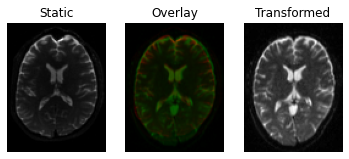

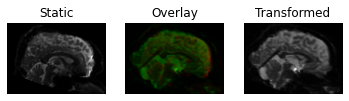

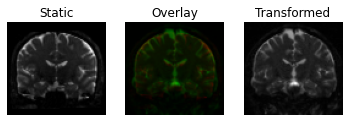

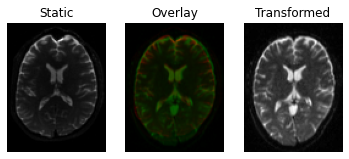

In [19]:
transformed = affine.transform(moving)

#plotted 3 slices of registration results with affline transform after using MI
regtools.overlay_slices(static, transformed, None, 0,
                        "Static", "Transformed", "transformed_affine_0.png")
regtools.overlay_slices(static, transformed, None, 1,
                        "Static", "Transformed", "transformed_affine_1.png")
regtools.overlay_slices(static, transformed, None, 2,
                        "Static", "Transformed", "transformed_affine_2.png")


.. [[Mattes]](https://elef.soic.indiana.edu/documentation/0.15.0.dev/examples_built/affine_registration_3d/#id1) Mattes, D., Haynor, D. R., Vesselle, H., Lewellen, T. K.,
              Eubank, W. (2003). PET-CT image registration in the chest using
              free-form deformations. IEEE Transactions on Medical Imaging,
              22(1), 120-8.
              
.. [[Avants]](https://elef.soic.indiana.edu/documentation/0.15.0.dev/examples_built/affine_registration_3d/#id3) Avants, B. B., Tustison, N., & Song, G. (2011). Advanced
              Normalization Tools (ANTS), 1-35.
.. include:: ../links_names.inc